# Figure 5 Gene Trajectories

### Temporal drift in gene embedding space during aging: gene variance to youngest group

In [ ]:
import scanpy as sc 
adata = sc.read_h5ad("chunk3562_stress_tumor_repair2.h5ad")

In [ ]:
gene_functions = {
    "ATR": "DNA Repair", #same
    "TDP2": "DNA Repair", #up
    "SAFB2": "Stress Response", #up
    "HERPUD1": "Stress Response", #down
    "MCTP1": "Oxidative Stress", #up
    "HEBP2": "Oxidative Stress", #down
    "SESN1": "Oxidative Stress", #same
    "APC": "Tumor Suppressor", #up
    "MKRN1": "Tumor Suppressor",  #same
    "BANP": "Tumor Suppressor", #down
    "IFITM3":"Immune Response"
}
function_colors = {
    "DNA Repair": "purple",
    "Stress Response": "teal",
    "Oxidative Stress": "orange",
    "Tumor Suppressor": "red",
    "Immune Response":"blue"
}
age_order = ["<20", "20-40", "40-60", "60-80", ">80"]

from scipy.stats import ttest_ind

def p_2_sign(p):
    """Convert p-value to significance markers."""
    if p < 0.001:
        return '***'
    elif p < 0.01:
        return '**'
    elif p < 0.05:
        return '*'
    else:
        return ''

def cal_p(lst1, lst2, stars = True):
    t_stat, p_value = ttest_ind(lst1, lst2, equal_var=False) # weich t-test bc unequal sample sizes
    if stars:
        return p_2_sign(p_value)
    else:
        return p_value

In [ ]:
from utils import sim_gene_youngest
gene2youngest_each_group = {}
ref_age = "<20"
do_for_these_genes = gene_functions.keys()
for gene in do_for_these_genes:
    adata_sub = adata[(adata.obs[f'{gene}_embedding_status'] == "present") & (adata.obs["disease"] == "normal")]
    adata_sub = adata_sub[~adata_sub.obs["age_group_20"].isin(["unknown"])]
    gene_embeddings = adata_sub.obsm[f'{gene}_embeddings'] 
    age_groups = adata_sub.obs['age_group_20'].to_list()
    gene2youngest_each_group[gene] = sim_gene_youngest(gene_embeddings, age_group_list=age_groups, ref_age = ref_age, age_order=age_order)

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
for gene, age_values in gene2youngest_each_group.items():
    data = []
    mean = np.mean(age_values[ref_age])
    for age, sims in age_values.items():
        for sim in sims:
            data.append({"age group": age, "cosine similarity": sim-mean})
    df = pd.DataFrame(data)
    df['age group'] = pd.Categorical(df['age group'], categories=age_order, ordered=True)

    plt.figure(figsize=(8, 6))
    sns.lineplot(data=df, x="age group", y="cosine similarity", marker='o')
    plt.title(f"cosine similarity compare to <20 for {gene}", fontsize=20)
    plt.xlabel('age group', fontsize=16)
    plt.ylabel('adjusted cosine similarity', fontsize=16)
    plt.ylim(-0.5,0.1)
    ylim = plt.gca().get_ylim()
    
    plt.tight_layout()
    #plt.show()
    plt.savefig(f'paper_plots/compare_gene2youngest/{gene}_withP.png', dpi=300, bbox_inches='tight')
    plt.close()

### Gene split 


In [1]:
import pandas as pd 

gene_trajectories = pd.read_pickle('../saved_trajectories.pkl')
display(gene_trajectories.shape, gene_trajectories.sample())

(5917, 15)

,young_sim_x,young_sim_y,age_sim_x,age_sim_y,drift,null_dist,z,pval,fdr,dissipative,significant,young_sim_x_raw,young_sim_y_raw,recurrence,divergence
ZNF232,"[20, 40, 60, 80, 100]","[0.44033912, 0.46159166, 0.44451597, 0.4348327...","[20, 40, 60, 80, 100]","[0.14535505, 0.094981834, 0.12279104, 0.136262...",0.021253,"[0.038947165, 0.030955791, 0.058615237, 0.0301...",-1.602185,0.945443,0.963549,Conservative,False,"[20, 40, 60, 80, 100]","[[0.5214641, 0.15107822, 0.260912, 0.430075, 0...",0.88,0.010148


<Figure size 800x600 with 0 Axes>

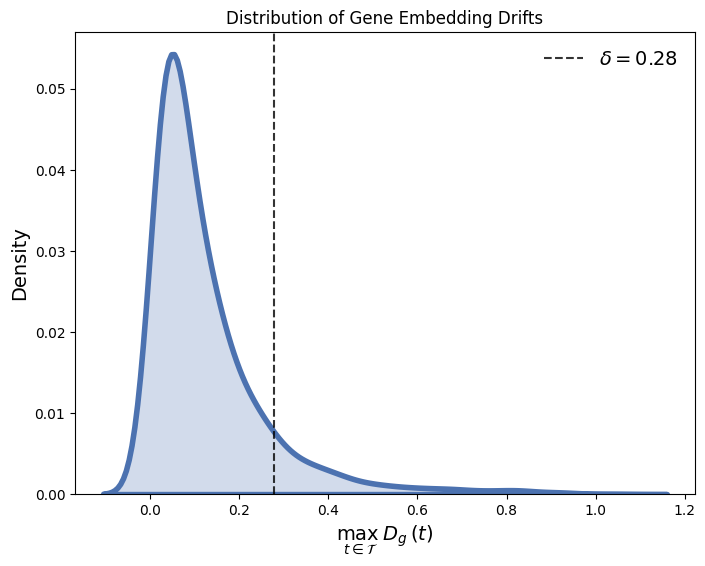

In [119]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import gaussian_kde
from matplotlib.ticker import FuncFormatter
import numpy as np

dip_value = np.percentile(gene_trajectories['drift'], 90,)
plt.figure(figsize=(8,6))

sns.kdeplot(gene_trajectories['drift'], fill=True, color=sns.color_palette('deep', n_colors=1)[0], lw=4, bw_adjust=1.5)
if dip_value:
    plt.axvline(dip_value, color='black', linestyle='--', alpha=0.8, label=f"$\delta = {dip_value:.2f}$")
plt.xlabel('$\max_{ \: t \in \mathcal{T}}\:  D_{g}(t)$', fontsize=14)
plt.title('Distribution of Gene Embedding Drifts')
plt.ylabel('Density', fontsize=14)
plt.legend(frameon=False, fontsize=14)
ax = plt.gca()
#ax.spines['top'].set_visible(False)
#ax.spines['right'].set_visible(False)
ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{x/100:.2f}"))
plt.savefig('distribution_drifts.svg', bbox_inches='tight',dpi=300)
plt.show()

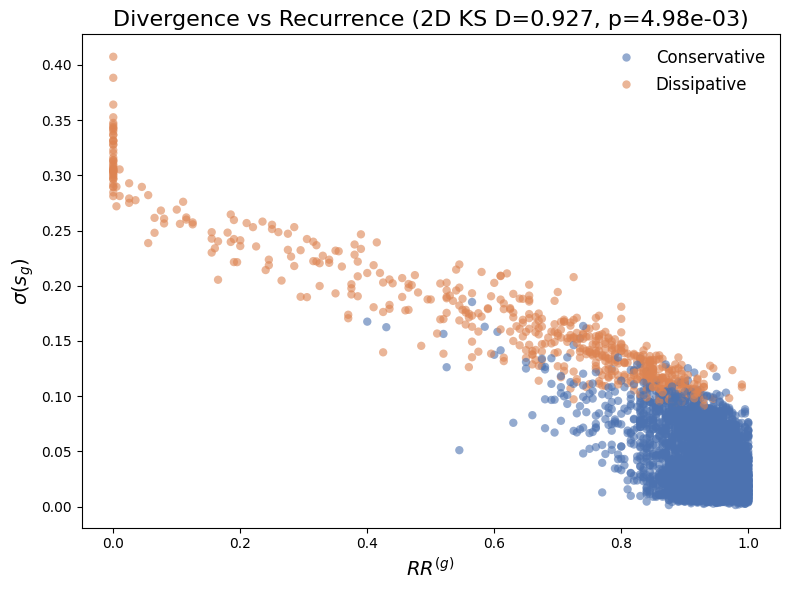

In [3]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def ks2d2samp(x1, y1, x2, y2, n_perm=500):
    """
    Fasano-Franceschini 2D KS statistic via permutation p-value.
    Returns (D, pvalue).
    """
    X1 = np.column_stack([x1, y1])
    X2 = np.column_stack([x2, y2])
    comb = np.vstack([X1, X2])
    n1 = len(X1)
    n2 = len(X2)
    N = n1 + n2

    def _empiric_cdf(pt, sample):
        """Fraction of points in sample ≤ pt in both dims."""
        return np.mean((sample[:,0] <= pt[0]) & (sample[:,1] <= pt[1]))

    D_obs = 0.0
    for pt in comb:
        F1 = _empiric_cdf(pt, X1)
        F2 = _empiric_cdf(pt, X2)
        D_obs = max(D_obs, abs(F1 - F2))

    # permutation null
    idx = np.arange(N)
    D_perm = np.zeros(n_perm)
    for i in range(n_perm):
        np.random.shuffle(idx)
        samp1 = comb[idx[:n1]]
        samp2 = comb[idx[n1:]]
        Dm = 0.0
        for pt in comb:
            F1 = np.mean((samp1[:,0] <= pt[0]) & (samp1[:,1] <= pt[1]))
            F2 = np.mean((samp2[:,0] <= pt[0]) & (samp2[:,1] <= pt[1]))
            Dm = max(Dm, abs(F1 - F2))
        D_perm[i] = Dm

    pval = (np.sum(D_perm >= D_obs) + 1) / (n_perm + 1)
    return D_obs, pval

def plot_drift_vs_trajectory(df, hue, n_perm=200):
    # split samples
    cats = df[hue].unique()
    a, b = cats
    rec1 = df.loc[df[hue]==a, 'recurrence'].values
    div1 = df.loc[df[hue]==a, 'divergence'].values
    rec2 = df.loc[df[hue]==b, 'recurrence'].values
    div2 = df.loc[df[hue]==b, 'divergence'].values

    D, p = ks2d2samp(rec1, div1, rec2, div2, n_perm)

    sns.reset_defaults()
    plt.figure(figsize=(8,6))
    sns.scatterplot(
        x=df['recurrence'],
        y=df['divergence'],
        hue=df[hue],
        palette='deep',
        edgecolor='none',
        alpha=0.6
    )
    plt.xlabel("$RR^{(g)}$", fontsize=14)
    plt.ylabel("$\sigma (s_g)$", fontsize=14)
    plt.title(f"Divergence vs Recurrence (2D KS D={D:.3f}, p={p:.2e})", fontsize=16)
    plt.legend(frameon=False, title="", fontsize=12)
    plt.tight_layout()
    plt.savefig('rec_vs_div.png', bbox_inches='tight',dpi=300)
    plt.show()

import random
sample_k_avg = lambda lst, k: np.array([np.mean(random.choices(sublist, k=k)) for sublist in lst])

def hopf_metrics(time_values, state_values, raw_state_values):
    recurrence = state_values.std()
    
    recurrence_rate = lambda x, epsilon: np.mean(np.linalg.norm(x[:, None] - x[None, :], axis=-1) < epsilon)
    recurrence =  np.mean([recurrence_rate(sample_k_avg(raw_state_values, k=5), epsilon=0.4)  for _ in range(40)])
    divergence = state_values.std()# np.abs(np.diff(state_values - state_values[0])).sum()
    return pd.Series({'recurrence': recurrence, 'divergence': divergence})

#gene_trajectories[['recurrence', 'divergence']] = gene_trajectories.apply(
#    lambda row: hopf_metrics(np.array(row['young_sim_x']), np.array(row['young_sim_y']), row['young_sim_y_raw']),
#    axis=1
#)
plot_drift_vs_trajectory(gene_trajectories, hue="dissipative")

/home/lleger/miniconda3/envs/gene/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


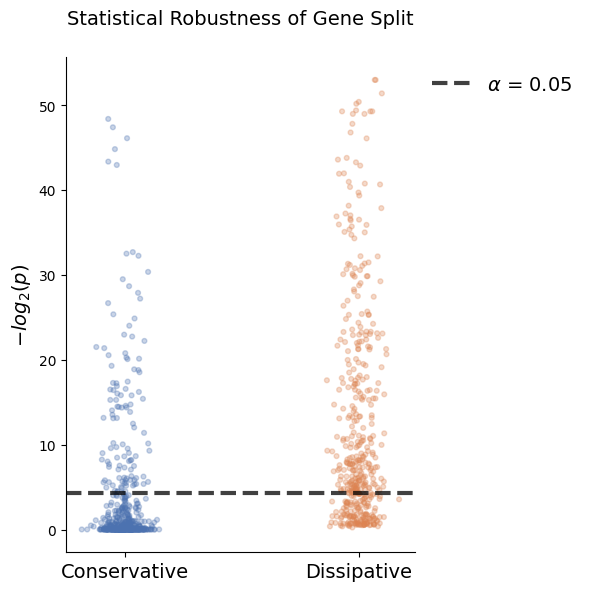

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.multitest import multipletests

colors = sns.color_palette("deep")

pvals_dissipative = gene_trajectories[(gene_trajectories['dissipative'] == "Dissipative")   ]['fdr']#& (gene_trajectories['significant'] == False)]['fdr']
pvals_conservative = gene_trajectories[(gene_trajectories['dissipative'] == "Conservative") ]['fdr'].sample(n=len(pvals_dissipative))#& (gene_trajectories['significant'] == False)]['fdr']
pvals_all = pd.concat([pvals_conservative, pvals_dissipative])

x = np.concatenate([
    np.random.normal(loc=-50, scale=5, size=len(pvals_conservative)),
    np.random.normal(loc=50, scale=5, size=len(pvals_dissipative))
])

group_labels = ['Conservative'] * len(pvals_conservative) + ['Dissipative'] * len(pvals_dissipative)
group_colors = [colors[0]] * len(pvals_conservative) + [colors[1]] * len(pvals_dissipative)

plt.figure(figsize=(6, 6))
plt.scatter(x, -np.log2(pvals_all), c=group_colors, s=12, alpha=0.3)

plt.axhline(-np.log2(0.05), linestyle='--', color='k', lw=3, alpha=0.75, label='$\\alpha$ = 0.05')
plt.xticks([-50, 50], ["Conservative", "Dissipative"], fontsize=14)#, ha='right', rotation=45)
plt.ylabel('$-log_2(p)$', fontsize=14)
plt.title('Statistical Robustness of Gene Split', fontsize=14, y=1.05)
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.legend(frameon=False, bbox_to_anchor=(1,1), fontsize=14)
plt.tight_layout()
plt.savefig('manhattan.svg', bbox_inches='tight',dpi=300)
plt.show()
